In [5]:
# Helper functions
def load_input(file_name):
    raw_input = []
    for line in open(file_name):
        raw_input.append(eval('(' + line + ')'))
    return raw_input

def categoryToInt(label):
    if(label == 'Books'):
        return 0
    if(label == 'Movies & TV'):
        return 1
    if(label == 'Music'):
        return 2
    return -1

In [6]:
# load data from files
def make_training(product_file_name, review_file_name):
    raw_products=load_input(product_file_name) 
    raw_reviews=load_input(review_file_name) 
    products_dict = {} 
    reviews_dict = {} 
    txts = []
    ys = []    
    asins=[] 
    
    for each_product in raw_products: 
        text = ''
        if('title' in  each_product.keys()):
            text += each_product['title']
        if('description' in  each_product.keys()):
            text += ' ' + each_product['description']
        category = categoryToInt(list(each_product['salesRank'].keys())[0])
        products_dict[each_product['asin']] = [category, text]
        
    for each_review in raw_reviews:
        txt = each_review['summary'] + ' ' + each_review['reviewText']
        if(each_review['asin'] in reviews_dict.keys()):
            reviews_dict[each_review['asin']] += txt
        else:
            reviews_dict[each_review['asin']] = txt

    for asin, review_words in reviews_dict.items():
        txts.append(review_words + products_dict[asin][1])
        ys.append(products_dict[asin][0])
        asins.append(asin)     
   
    return txts,ys

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

v = CountVectorizer(stop_words='english') 
def build_model(product_file_name="products.txt", review_file_name="reviews.txt"):
    texts, y = make_training(product_file_name, review_file_name)
    b = MultinomialNB()
    X = v.fit_transform(texts)
    b.fit(X, y)
    kbest = SelectKBest(mutual_info_classif, 730)
    Xnew=kbest.fit_transform(X,y)
    b.fit(Xnew,y)
    return b

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

def prepare_data(product_file_name, review_file_name):   
    txts, y = make_training(product_file_name, review_file_name)
    X = v.fit_transform(txts)
    kbest = SelectKBest(mutual_info_classif, 730)
    Xnew = kbest.fit_transform(X,y)
    return Xnew, y  

-----------------------------------------------------------------------------
### Documenting your Decisions


#### Evaluation and Analysis

In answering these questions, please be sure to show your work, for example output of commands you used to gather data supporting your decisions.   For each of the cells below containing a question, please leave the question header and text in the notbook you subnmit.  Put you answer in markdown in the same cell, and add additional cells below the question/answer cell for supporting data (output, tables, graphics).  I will evaluate your notebook from beginning to end prior to evaluating the model or reading your analysis.


----------------------------
#### Model Quality

What do you expect the accuracy of your model to be on a new set of product records it has not seen before?
How many variables are in your model?

#### ---Answer---
We expect an accuray similar to 0.9038. In order to double check the accuracy, we used new test data "products_test.txt", "reviews_test.txt" and got even better score 0.92. 

The variables in our model are two:
* stopwords='english'
* KBest of 730

In [11]:
from sklearn.model_selection import cross_val_score
def cross_validate(clf, x, y):
    return cross_val_score(clf,x,y,cv=10).mean()

In [12]:
our_model = build_model("products.txt", "reviews.txt")
X, y = prepare_data("products.txt", "reviews.txt")
print(X.shape)
print(f'Model accuracy on original training data: {cross_val_score(our_model, X, y, cv=10).mean()}')

(99, 730)
Model accuracy on original training data: 0.903888888888889


------------------------------------------------
#### Input Fields

What input fields from the product and review records did you include in training your model?
How did you decide which fields to use and which to omit?

#### ---Answer---

products:

| Field | Included? | decision |
|---|---|---|
| asin         | No  | It is most likely to be unique, so not giving enough information |
| brand        | No  | It is not representative. For example, brand Disney could be music, movies, or books |
| categories   | No  | Not allowed |
| description  | Yes | It is likely to have useful words like "Oscars award..", "Best seller book"|
| imUrl        | No  | URL characteres without much information |
| price        | No  | It is not representative. Some samples could have the same price for a book, music, and movies |
| related      | No  | Even though we could expect that realted asins be the same class, that could be not true all the time. The related items could be anything, for example Harry Potter book could be realted to Harry Potter movies, and Harry Potter BSO. In addition, we would be trusting on Amazon recomendation algorithm |
| salesRank    | Yes | Our ground truth (ys) |
| title        | Yes | May contain useful information, for example Scary Movie gives a clear hint about what it is |

reviews:

| Field | Included? | decision |
|---|---|---|
| asin           | No  |Most likely to be unique |
| helpful        | No  |A value that it is not realted to the class. Not because it is helpful at some degree means it is a book or anything else |
| overall        | No  | Same as "helpful". a book, a movie, and music disc could have the same overall  |
| reviewerID     | No  | A user could buy anything. Maybe some users tend to buy only books, but some day decided to buy a movie as a gift for someone else, so it is hard to predict the class based on a particular user|
| reviewerName   | No  | Users does not tend to buy a particular type of product just for the name they have |
| reviewText     | Yes | It is likely to have useful words like "read", "heard" |
| reviewTime     | No  | Users could buy any product at any time. No because some users commented a book at 3 PM means that all the reviews at 3 PM are books  |
| summary        | Yes | May contain useful information with words as description field ("read", "listen"..) |
| unixReviewTime | No  | same as reviewTime |

-------------------------------------------
#### Preprocessing

What preprocessing steps did you use?  At minimum you must evaluate stemming, tokenizing, stop word removal.  How did you decide which steps improved the model and which did not?

#### ---Answer---
we tried stemming and stop words removal in our model. Our decision in this part is "with stop words, without stemming".

To test if stemming works, we wrote function tokenize_and_stem(text) to serve as tokenizer parameter in CountVectorizer() instance. For simplicity of controlling other variables, we used MultinomialNB as classifier and CountVectorizer as vectorizer. The comparison of cross_vali score is as follow,


In [13]:
from sklearn.model_selection import cross_val_score
def cross_validate(clf, x, y):
    return cross_val_score(clf,x,y,cv=10).mean()

In [14]:
import nltk
from nltk.stem import PorterStemmer
import string

stemmer = PorterStemmer()
def tokenize_and_stem(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token.lower().strip(string.punctuation)
              for token in tokens if token.isalnum()]
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [15]:
from sklearn.naive_bayes import MultinomialNB

txts,y = make_training("products.txt","reviews.txt")
nb=MultinomialNB()

v =  CountVectorizer(tokenizer=tokenize_and_stem)
X = v.fit_transform(txts) 
print(f"preprocessing with stemming {cross_validate(nb, X, y)}")

v =  CountVectorizer()
X = v.fit_transform(txts) 
print(f"preprocessing without stemming {cross_validate(nb, X, y)}")


preprocessing with stemming 0.7255555555555556
preprocessing without stemming 0.7577777777777779


From above comparison, we found stemming decreased our score, so we forsook stemming. To test if stop words works, we set parameter stop_words as "english" in CountVectorizer(), the comparison results are as follow,




In [16]:
txts,y = make_training("products.txt","reviews.txt")
nb=MultinomialNB()

v =  CountVectorizer(stop_words='english')
X = v.fit_transform(txts) 
print(f"preprocessing with stop words {cross_validate(nb, X, y)}")

v =  CountVectorizer()
X = v.fit_transform(txts) 
print(f"preprocessing without stop words {cross_validate(nb, X, y)}")

preprocessing with stop words 0.8027777777777778
preprocessing without stop words 0.7577777777777779


From above comparison, the score got improved by adding stop_words parameter, so we decided to keep it. 

---------------------------------------------
#### Vectorization

What technique did you use to turn the input features into a feature vector?  How did you make that choice?

#### ---Answer---
While in previous part we set CountVectorizer as fixed vectorzier for testing stemming and stop_words removal, we would go one step back and show why we chose CountVectorizer. Below are the perfomance of CountVectorizer and TfidfVectorizer performance based on MultinomialNB classifier.

In [17]:
from sklearn.model_selection import cross_val_score
def cross_validate(clf, x, y):
    return cross_val_score(clf,x,y,cv=10).mean()

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

txts,y=make_training("products.txt", "reviews.txt")
nb = MultinomialNB()

v = CountVectorizer()
X = v.fit_transform(txts) 
print(f"Count Vectorizer score {cross_validate(nb, X, y)}")

v = TfidfVectorizer()   
X = v.fit_transform(txts)   
print(f"Tfidf Vectorizer score {cross_validate(nb, X, y)}")


Count Vectorizer score 0.7577777777777779
Tfidf Vectorizer score 0.6444444444444446


From above comparison, CountVectorizer() behaved 11% better than TfidfVectorizer(), so we decided to use CountVectorizer(). Then we were teawking the default parameters inside CountVectorizer() for possible better performance, for example, perhaps bi-gram or one-gram? Also we can consider adding the stop_words parameter from last document part into CountVectorizer() to see how it behaves. Following are results from combinations of different parameters inside CountVectorizer().

In [19]:
v = CountVectorizer()
X = v.fit_transform(txts) 
print(f"Count Vectorizer with default parameter {cross_validate(nb, X, y)}")

bigram_vector =  CountVectorizer(ngram_range=(1, 2),token_pattern=r'\b\w+\b')
X= bigram_vector.fit_transform(txts)
print(f"Bigram Count Vectorizer without stop_words: {cross_validate(nb, X, y)}")

v = CountVectorizer(stop_words='english') 
X = v.fit_transform(txts)
print(f"Count Vectorizer with stop_words:{cross_validate(nb, X, y)}")

bigram_vector =  CountVectorizer(stop_words='english',ngram_range=(1, 2),token_pattern=r'\b\w+\b')
X= bigram_vector.fit_transform(txts)
print(f"Bigram Count Vectorizer with stop_words: {cross_validate(nb, X, y)}")

Count Vectorizer with default parameter 0.7577777777777779
Bigram Count Vectorizer without stop_words: 0.7661111111111112
Count Vectorizer with stop_words:0.8027777777777778
Bigram Count Vectorizer with stop_words: 0.6883333333333334


Above are four situations with two parameter variables: n-gram tokenization and stop_words. Interstingly, we found though CountVectorizer with bi-gram token behaved a bit better than one-gram vector(0.76>0.75), but once adding stop words, bi-gram vectorizer dropped to 0.68 while one-gram vectorizer improved to 0.80. So we made the decision to use one-gram CountVecorizer() with stop_words as parameter in this step. 

---------------------------------------------
####  Feature Selection

It is important to examine and understand the model features both to convince that the important features are plausible, and to consider removing the unimportant features.  What features did you use in the model, and how did you make that choice?  List some of the most important features.  Are you convinced that they are are accurate exemplars of the class, or might they be artifacts of the training set?  List some of the least important features -- do they suggest ways to cut down the model size without significantly affecting accuracy?  

#### ---Answer---
In class we looked at three ways of estimating the impact of a term on a model

* <b>Frequency-based selection</b>

As demonstrated, we decided to use stopwords. In addition to that we checked different values of min_df and max_df in our model. However, none of the adjustements of min_df and max_df improved the model enough, so we decided not use them in our best model


The best min_df was 0.03

The best max_df is around 0.4 but it doesn't show a strong improvement




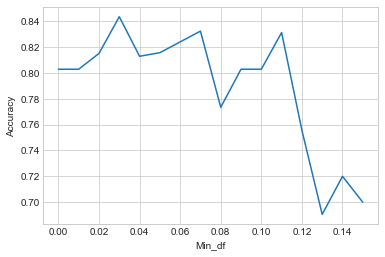

In [20]:
#min_df
xval = []
yval = []
m = 0.0
while(m <= 0.15):
    xval.append(m)
    stopwords =  CountVectorizer(stop_words='english', min_df=m)
    X= stopwords.fit_transform(txts)
    yval.append(cross_validate(nb, X, y))
    m = m + 0.01
    
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('Min_df')
ax.set_ylabel('Accuracy')
ax.plot(xval, yval);    

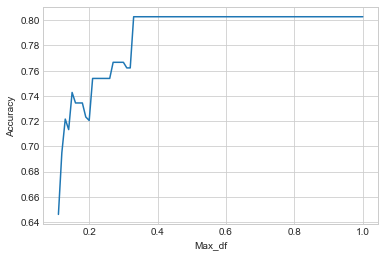

In [21]:
# max_df
xval = []
yval = []
m = 1.0
while(m >= 0.1):
    xval.append(m)
    stopwords =  CountVectorizer(stop_words='english',max_df=m)
    X= stopwords.fit_transform(txts)
    yval.append(cross_validate(nb, X, y))
    m = m - 0.01

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('Max_df')
ax.set_ylabel('Accuracy')
ax.plot(xval, yval);   

* <b>Mutual information</b>


We selected our KBest by using mutual information measure. We did it by exploration on the graph. Our options were: 
* no parameters (no stop_words or min_dif addded)
* stop_word without min_df 
* stop_word with min_df

The decision was to use 730 Kbest features

Exploration:

* The first option gave us KBest 1150 and accuracy of 0.8866666666666667
* Second option gave us KBest 730 and accuracy of 0.903888888888889
* Third option gave us KBest 50 and accuracy of 0.9366666666666668


We decided to use option b KBest with 730. Using only 50 features might be too low and too aligned to training data (overfitting)

In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

def k_features_x(k, X, y, fs=mutual_info_classif):
    kbest = SelectKBest(fs, k=k)  
    return kbest.fit_transform(X, y)


def k_features_accuracy(k, clf, X, y, fs=mutual_info_classif): 
     # changed matrix 
    X_new = k_features_x(k, X, y, fs)
    return cross_validate(clf, X_new, y) 

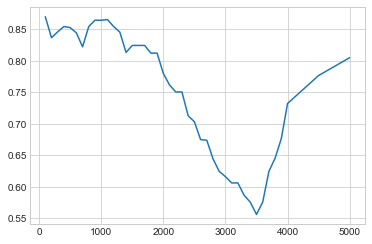

In [23]:
# without parameters, all features
nb = MultinomialNB()
v = CountVectorizer()
X = v.fit_transform(txts)

xval = []
yval = []
for k in range(100, 4000, 100):   
    xval.append(k)
    yval.append(k_features_accuracy(k, nb, X, y))

for k in range(4000, X.shape[1], 500):
    xval.append(k)
    yval.append(k_features_accuracy(k, nb, X, y))

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax = plt.axes()
ax.plot(xval, yval);

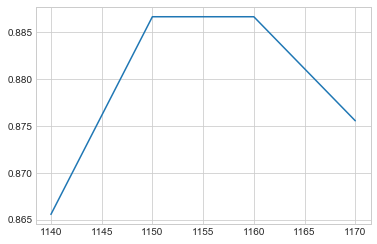

In [24]:
# without parameters, region of interest [1140, 1180]
nb = MultinomialNB()
v = CountVectorizer()
X = v.fit_transform(txts)

xval = []
yval = []
for k in range(1140, 1180, 10):   # 
    xval.append(k)
    yval.append(k_features_accuracy(k, nb, X, y))

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax = plt.axes()
ax.plot(xval, yval);

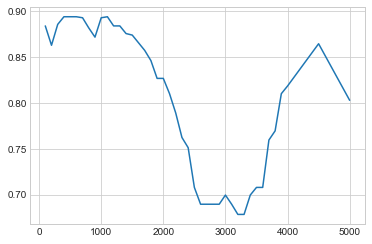

In [25]:
# WITH stop_words, all features
nb = MultinomialNB()
v = CountVectorizer(stop_words='english')
X = v.fit_transform(txts)

xval = []
yval = []
for k in range(100, 4000, 100):   # 
    xval.append(k)
    yval.append(k_features_accuracy(k, nb, X, y))

for k in range(4000, X.shape[1], 500):
    xval.append(k)
    yval.append(k_features_accuracy(k, nb, X, y))

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax = plt.axes()
ax.plot(xval, yval);

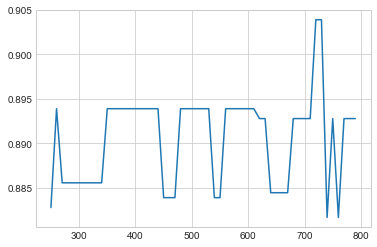

In [26]:
# WITH stop_words, region of interest [250, 800]
nb = MultinomialNB()
v = CountVectorizer(stop_words='english')
X = v.fit_transform(txts)

xval = []
yval = []
for k in range(250, 800, 10):   
    xval.append(k)
    yval.append(k_features_accuracy(k, nb, X, y))

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax = plt.axes()
ax.plot(xval, yval);

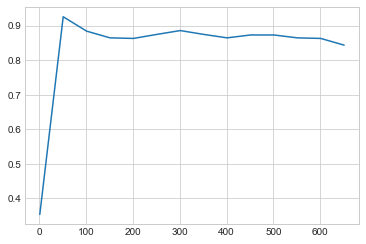

In [27]:
# with stop_words and min_df, all the features
nb = MultinomialNB()
v = CountVectorizer(stop_words='english', min_df=0.03)
X = v.fit_transform(txts)

xval = []
yval = []

for k in range(1, X.shape[1], 50):
    xval.append(k)
    yval.append(k_features_accuracy(k, nb, X, y))

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax = plt.axes()
ax.plot(xval, yval);

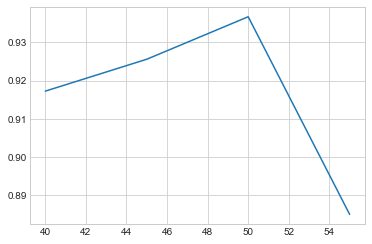

In [28]:
#with stop_words and min_df, Region of interest [40, 60]
nb = MultinomialNB()
v = CountVectorizer(stop_words='english', min_df=0.03)
X = v.fit_transform(txts)

xval = []
yval = []

for k in range(40, 60, 5):
    xval.append(k)
    yval.append(k_features_accuracy(k, nb, X, y))

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax = plt.axes()
ax.plot(xval, yval);

In [29]:
# Accuracy Comparison
print(k_features_accuracy(1150, MultinomialNB(), CountVectorizer().fit_transform(txts), y))
print(k_features_accuracy(730, MultinomialNB(), CountVectorizer(stop_words='english').fit_transform(txts), y))
print(k_features_accuracy(50, MultinomialNB(), CountVectorizer(stop_words='english', min_df=0.03).fit_transform(txts), y))

0.8866666666666667
0.903888888888889
0.9366666666666668


* <b>Feature log probabilities</b>, i.e. $P(f_i | C)$ 

We did not explore using feature log probabilies because we have three categories making it difficult to execute.




* <b>Important Features (in order)</b>:

    * Books: Book, life, books, writen

    * Movies & TV: film, like, time, good

    * Music: music, op, song, cd

Important features make sense to be related to each class. However, for Movies & TV the words like, time, and good are not very realted to a movie. Probably the reviews in the training data showed mostly good reviews for movies, but we cannot be sure about that for test data.


* <b>Least Important Features</b>:

We got very rare least important features such as numbers, or years. Maybe we could explore more the extraction of these values.

Some examples are: 000, 102, 2000, 1990s

<b> Analysis </b>

How different are the three measures, i.e. do they all tend to rank the same variables as significant and insignificant?  Which did you use in your model, and why?

We decided to use KBest according to mutual information in addition to the stopwords. because it gave us an improved accuracy without a radical decrease in the number of features. 

In [30]:
""" important Features"""
def important_features(vectorizer,classifier,n=20):
    feature_names =vectorizer.get_feature_names()
    #bad features
    frac_and_name_book = sorted(zip(classifier.feature_log_prob_[0], feature_names),reverse=False)[:n]
    frac_and_name_movies = sorted(zip(classifier.feature_log_prob_[1], feature_names),reverse=False)[:n]   
    frac_and_name_music = sorted(zip(classifier.feature_log_prob_[2], feature_names),reverse=False)[:n]
    
    #good features
    frac_and_name_book = sorted(zip(classifier.feature_log_prob_[0], feature_names),reverse=True)[:n]
    frac_and_name_movies = sorted(zip(classifier.feature_log_prob_[1], feature_names),reverse=True)[:n]   
    frac_and_name_music = sorted(zip(classifier.feature_log_prob_[2], feature_names),reverse=True)[:n]
    
    
    print(f"Important words BOOK")
    for coef, feat in frac_and_name_book:
        print(coef, feat)
    print("==========")
    print(f"Important words MOVIES & TV")
    for coef, feat in frac_and_name_movies:
        print(coef, feat)
    print("==========")
    print(f"Important words MUSIC")
    for coef, feat in frac_and_name_music:
        print(coef, feat)

In [31]:
txts,y = make_training("products.txt","reviews.txt")

v = CountVectorizer(stop_words='english')
X = v.fit_transform(txts)
b = MultinomialNB()
b.fit(X, y)
important_features(v, b, n=20)

Important words BOOK
-4.73709772903064 book
-6.049284117996809 life
-6.049284117996809 books
-6.149367576553791 written
-6.149367576553791 new
-6.149367576553791 like
-6.149367576553791 good
-6.32121783348045 wesley
-6.32121783348045 read
-6.32121783348045 great
-6.385756354618021 reading
-6.385756354618021 people
-6.385756354618021 patients
-6.385756354618021 mdash
-6.454749226104973 world
-6.454749226104973 university
-6.454749226104973 author
-6.528857198258695 writing
-6.528857198258695 walser
-6.528857198258695 information
Important words MOVIES & TV
-5.9760336000774394 film
-6.018593214496235 like
-6.158355156871394 time
-6.158355156871394 good
-6.2096484512589445 movie
-6.2096484512589445 dvd
-6.320874086369169 new
-6.381498708185603 just
-6.381498708185603 great
-6.446037229323174 series
-6.5891380729638485 western
-6.5891380729638485 music
-6.5891380729638485 master
-6.5891380729638485 love
-6.669180780637385 years
-6.669180780637385 way
-6.669180780637385 big
-6.7561921576270

-------------------------------------------------
#### Algorithm

Which classification algorithm did you use;  what alternatives did you explore and how did you make the choice?  What hyperparameter optimization did you perform?

#### ---Anwser---
We chose MultinomialNB as the final classifier. In this part, we want to justify why we made this decision.

To begin with two versions of Naive Bayes classifier, Bernoulli models the presence/absence of a feature; Multinomial models the number of counts of a feature. That is to say, MultinomialNB will classify a document based on the counts it finds of multiple keywords; whereas Bernoulli NB can only focus on a single keyword. The data we processed have many features and we believe the counts of some terms matter in classfiying the class. So we chose MultinomialNB over BernoulliNB. 

Secondly, comparing MuitlnomialNB with Rochhio classifier and KNN classifier, the results are displayed as follow, each classifier now with default setting. 

Notice: following comparisons are based on CountVectorizer() without stop_words parameter, also without selecting k best features.

In [32]:
from sklearn.model_selection import cross_val_score
def cross_validate(clf, x, y):
    return cross_val_score(clf,x,y,cv=10).mean()

In [33]:
txts,ys = make_training("products.txt","reviews.txt")

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer()
X = v.fit_transform(txts)

In [35]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [36]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
rocchio_clf =NearestCentroid()

In [37]:
from sklearn.neighbors import KNeighborsClassifier
knb_clf = KNeighborsClassifier()

In [38]:
print(f"Multinominal Naive Bayes {cross_validate(nb, X, y)}")
print(f"Nearest Centroid {cross_validate(rocchio_clf, X,y)}")
print(f"Nearest neighbors {cross_validate(knb_clf, X, y)}")

Multinominal Naive Bayes 0.7577777777777779
Nearest Centroid 0.4066666666666666
Nearest neighbors 0.45666666666666655


From above, Rocchio classifiers loses without further improvement space. But for KNN, we may try to ajust the hyperparameter "k" to see if we get huge leap. Below are two ways to cross check the optimal number of neighbors. The second way draws plot, from first graph, we could tell the optimal number falls on range [1,20], then we narrowed [1,88] to [1,20], finding the optimal number is 5. 

In [39]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(knb_clf, {'n_neighbors': range(1,88,1)}, cv=10, scoring='accuracy')
clf.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(1, 88)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [40]:
clf.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

Text(0, 0.5, 'Accuracy')

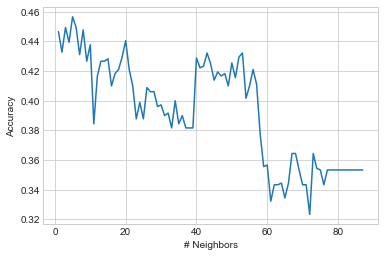

In [41]:
neighbors = []
accuracies = []

for nn in range(1,88,1):
    neighbors.append(nn)
    accuracies.append(cross_validate(KNeighborsClassifier(n_neighbors=nn), X, y))
    
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
ax.plot(neighbors, accuracies);
ax.set_xlabel('# Neighbors')
ax.set_ylabel("Accuracy")


Text(0, 0.5, 'Accuracy')

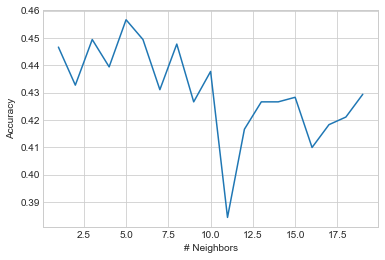

In [42]:
neighbors = []
accuracies = []

for nn in range(1,20,1):
    neighbors.append(nn)
    accuracies.append(cross_validate(KNeighborsClassifier(n_neighbors=nn), X, y))
    
# (x,y) line plot
# The dip between 5 and 10 is odd, but it's a common pattern to see
#  accuracy increase, peak for a while, then decrease
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
ax.plot(neighbors, accuracies);
ax.set_xlabel('# Neighbors')
ax.set_ylabel("Accuracy")

In [43]:
# using k nearest neighbor classifier with optimal 5
from sklearn.neighbors import KNeighborsClassifier
knb_clf = KNeighborsClassifier(n_neighbors=5)
print(f"Nearest neighbors {cross_validate(knb_clf, X, y)}")

Nearest neighbors 0.45666666666666655


It turns out the best number of neighbor happens to be the default settting, but accuracy score 0.456 is much overshawdowed by 0.75 of MultinomialNB. So we stick to MultinomialNB. 

----------------------------------------
#### Understanding Misclassifications

Even though misclassifications are inevitable, it is important to understand *why* your algorithm makes errors, and whether it is making "understandable" errors.   Choose several examples of misclassification and informally explain why you believe the classifier made the wrong choice.  Is/was there anything you might be able to do in terms of feature engineering to fix some misclassifications?

#### ---Answer---
Through the evolution of parameter exploring, now our model final score reaches 0.903, good but not enough. So we printed out the misclassification as the professor instructed. After that we took a close look at examples. 

In [44]:
from sklearn.model_selection import cross_val_score
def cross_validate(clf, x, y):
    return cross_val_score(clf,x,y,cv=10).mean()

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

nb = MultinomialNB()
v = CountVectorizer(stop_words='english')
txts,y = make_training("products.txt", "reviews.txt")
X = v.fit_transform(txts)
kbest = SelectKBest(mutual_info_classif, 730)
X=kbest.fit_transform(X,y)
nb.fit(X,y)

cross_validate(nb, X, y)

0.903888888888889

In [46]:
import numpy as np

y_pred = our_model.predict(X)
mask = y_pred != np.array(y)
misclassed = np.array(list(zip(range(0,len(y_pred)), zip(y, y_pred))),object)
misclassed[mask]

array([[80, (2, 1)]], dtype=object)

In [47]:
#[80, (2, 1)]
print(txts[80])   
print(y[80])

Rio 2 Fantastic  music I cannot wait to see the movie and buy the DVD.Takes me away to Rio. Just close your eyes and your there.
2


The above example is actually "Music" but misclassified as "Movie & TV". Taking a close look at review which contains imporantnt features like "movie, DVD" which is highly relevant to "Movie & TV" class. 